In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn

try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4177, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 4177 (delta 61), reused 104 (delta 38), pack-reused 4035 (from 1)
Receiving objects: 100% (4177/4177), 651.42 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (2432/2432), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
# Get ddataset
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# download image folder if it doesn't exist...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak and sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # remove .zip file
  os.remove(data_path / 'pizza_steak_sushi.zip')


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
from torchvision import transforms
# Setup transform manually
manual_transform =transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Create training and testing DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32

)

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights

EfficientNet_B2_Weights.IMAGENET1K_V1

In [8]:
# get the transforms used to create the pretrained weightd
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Create training and testing dataloaders with auto transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

In [10]:
model = torchvision.models.efficientnet_b2(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 67.5MB/s]


In [11]:
!pip install -q torchinfo
from torchinfo import summary
# Print a summary using torchinfo
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]
│    │    └─MBConv (0)                                       [32, 32, 112, 112]   [32, 16, 112, 112]
│    │    └─MBConv (1)                                       [32, 16, 112, 112]   [32, 16, 112, 112]
│    └

In [12]:
# Freeze all base layers in the features section of the model
for param in model.features.parameters():
  param.requires_grad=False

In [13]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [14]:
summary(model,
        input_size=(32,3,224,224),
        verbose=0,
        col_names=["input_size", "output_size"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112, 112]
│    │    └─MBConv (0)                                       [32, 32, 112, 112]   [32, 16, 112, 112]
│    │    └─MBConv (1)                                       [32, 16, 112, 112]   [32, 16, 112, 112]
│    └─Se

In [15]:
# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
# set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# end the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9741 | train_acc: 0.5833 | test_loss: 0.7291 | test_acc: 0.9284
Epoch: 2 | train_loss: 0.6694 | train_acc: 0.8896 | test_loss: 0.5819 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5551 | train_acc: 0.8542 | test_loss: 0.4711 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4527 | train_acc: 0.8708 | test_loss: 0.4098 | test_acc: 0.9597
Epoch: 5 | train_loss: 0.4164 | train_acc: 0.8917 | test_loss: 0.3627 | test_acc: 0.9659
Epoch: 6 | train_loss: 0.3604 | train_acc: 0.8979 | test_loss: 0.3365 | test_acc: 0.9506
Epoch: 7 | train_loss: 0.3245 | train_acc: 0.9187 | test_loss: 0.3068 | test_acc: 0.9443
Epoch: 8 | train_loss: 0.3121 | train_acc: 0.9229 | test_loss: 0.2950 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3533 | train_acc: 0.8750 | test_loss: 0.2689 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2467 | train_acc: 0.9500 | test_loss: 0.2583 | test_acc: 0.9534
[INFO] Total training time: 1630.810 seconds


[INFO] couldn't find helper functions.py, downloading


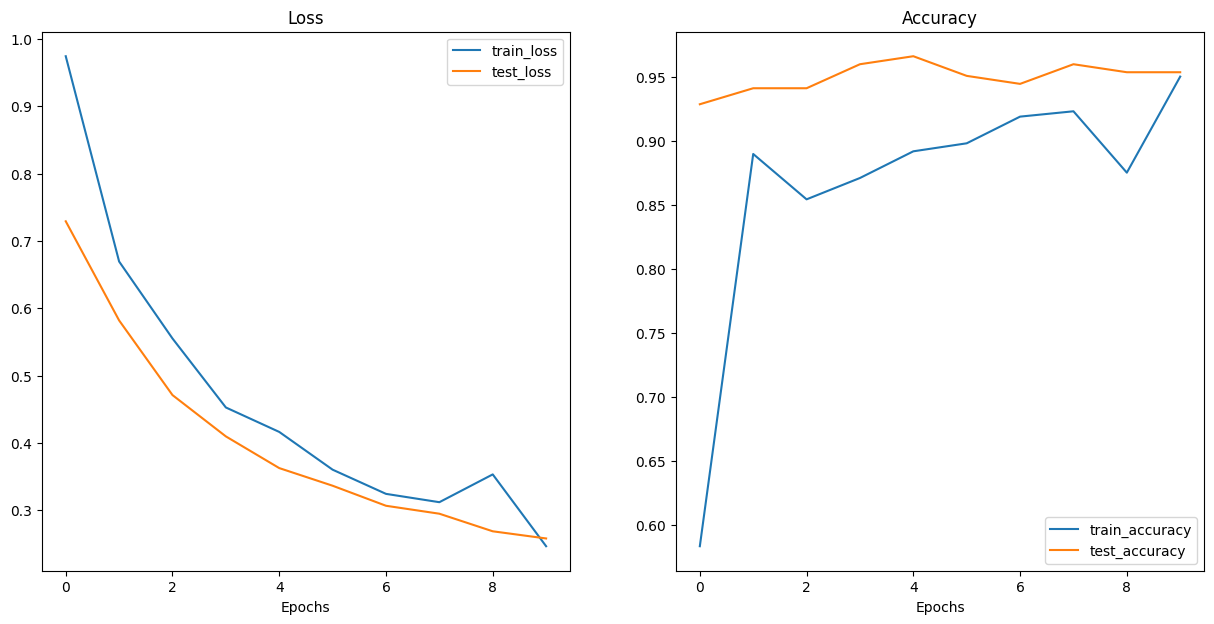

In [17]:
# Get the plot loss_curve function from helper_functions.py
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] couldn't find helper functions.py, downloading")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [18]:
from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):

  # open image
  img = Image.open(image_path)

  # Create transformation for image
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # predict on image
  model.to(device)

  # turn on model evaluation mode
  model.eval()
  with torch.inference_mode():
    # transform and add an extra dimension to image
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # Make prediction on image with extra dimension and send to target device
    target_image_pred = model(transformed_image.to(device))

  # convert logits to prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # convert prediction probabilities to prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);



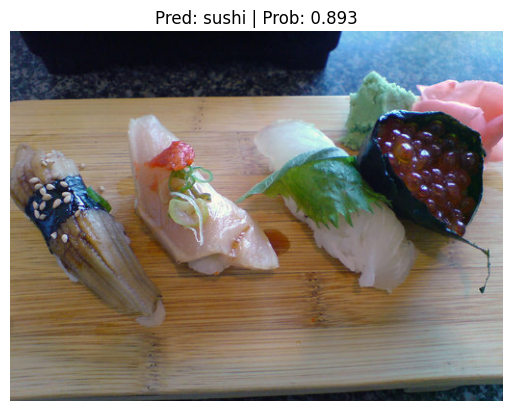

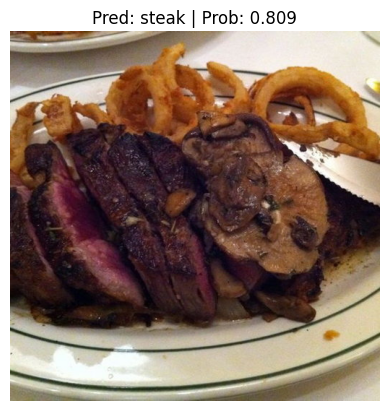

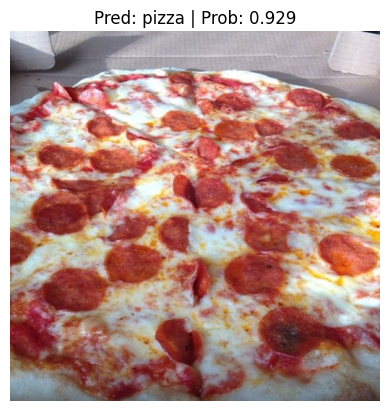

In [19]:

# Get random list of image paths from test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path = image_path,
                      class_names=class_names,
                      transform=weights.transforms(),
                      image_size=(224,224))

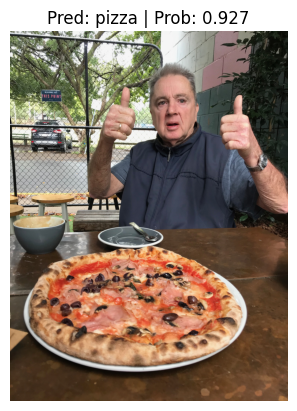

In [20]:
# Make predictions on custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesnt already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [21]:
# predicting on test data
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)

    y_logit = model(X)

    y_pred = torch.softmax(y_logit, dim=1)
    pred_label = torch.argmax(y_pred, dim=1)
    y_preds.append(pred_label)

y_pred_tensor = torch.cat(y_preds)



In [22]:
!pip install -q torchmetrics -U mlxtend
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 10.6 MB/s eta 0:00:00


In [23]:
import mlxtend

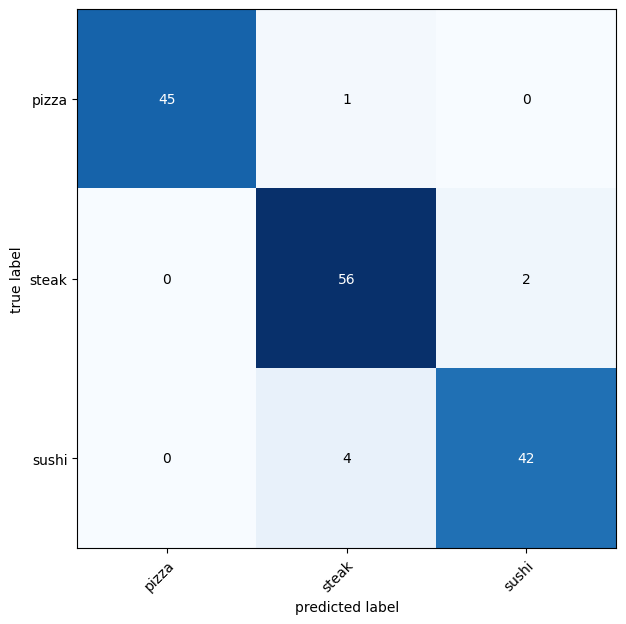

In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# get truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])

# Setup confusion matric instance
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_truth)

# plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7))

In [25]:
!wget https://images.unsplash.com/photo-1432139509613-5c4255815697
!cp photo-1432139509613-5c4255815697 steak.jpg


--2024-08-26 14:51:16--  https://images.unsplash.com/photo-1432139509613-5c4255815697
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1969147 (1.9M) [image/jpeg]
Saving to: ‘photo-1432139509613-5c4255815697’

photo-1432139509613 100%[===================>]   1.88M  --.-KB/s    in 0.1s    

2024-08-26 14:51:16 (19.3 MB/s) - ‘photo-1432139509613-5c4255815697’ saved [1969147/1969147]



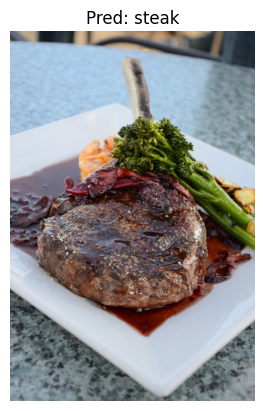

In [26]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False)

pred_and_plot(image_path="steak.jpg",
              model=model,
              transform=manual_transform,
              class_names=class_names)

--2024-08-26 14:51:22--  https://plus.unsplash.com/premium_photo-1673439304183-8840bd0dc1bf
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7306895 (7.0M) [image/jpeg]
Saving to: ‘premium_photo-1673439304183-8840bd0dc1bf’

premium_photo-16734 100%[===================>]   6.97M  --.-KB/s    in 0.1s    

2024-08-26 14:51:23 (49.2 MB/s) - ‘premium_photo-1673439304183-8840bd0dc1bf’ saved [7306895/7306895]



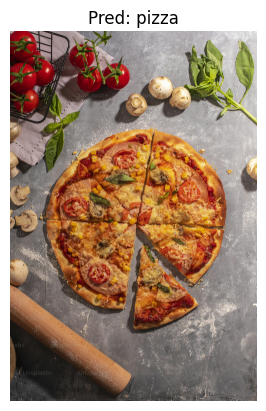

In [27]:
!wget https://plus.unsplash.com/premium_photo-1673439304183-8840bd0dc1bf
!cp premium_photo-1673439304183-8840bd0dc1bf pizza.jpg

pred_and_plot("pizza.jpg",
              model=model,
              transform=manual_transform,
              class_names=class_names)

--2024-08-26 14:51:42--  https://plus.unsplash.com/premium_photo-1668146927669-f2edf6e86f6f
Resolving plus.unsplash.com (plus.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to plus.unsplash.com (plus.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3166104 (3.0M) [image/jpeg]
Saving to: ‘premium_photo-1668146927669-f2edf6e86f6f’

premium_photo-16681 100%[===================>]   3.02M  --.-KB/s    in 0.1s    

2024-08-26 14:51:42 (27.0 MB/s) - ‘premium_photo-1668146927669-f2edf6e86f6f’ saved [3166104/3166104]



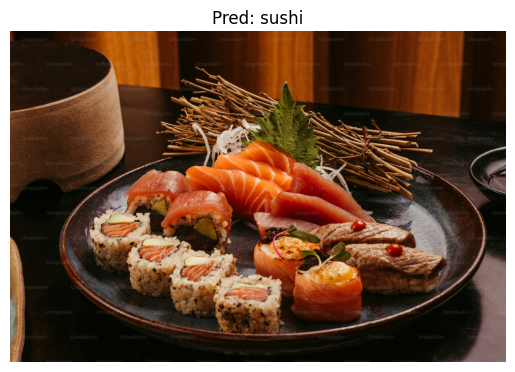

In [28]:
!wget https://plus.unsplash.com/premium_photo-1668146927669-f2edf6e86f6f
!cp premium_photo-1668146927669-f2edf6e86f6f sushi.jpg

pred_and_plot("sushi.jpg",
              model=model,
              transform=manual_transform,
              class_names=class_names)